import modules

In [1]:
# @title imports
from typing import Callable, List, Tuple
import sys
sys.path.insert(0, "../../")
sys.path.insert(0, '../../../abc')
import torch as t
from torch.distributions import normal, uniform
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import Image
from IPython import display
from tqdm import tqdm
import time
from model import init_grids, model
from vis_utils import visualize_batch, visualize_sequence
from utils import chop_and_shuffle_data
from helpers import gaussian_pdf
from distance_funcs import S1, mean_sq_distance

c:\Users\jsche\anaconda3\envs\torchenv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Experiment 5 - Comparing ABC and gradient-based approach

In [2]:
def abc_prc(
    X: t.Tensor,
    Y_obs: t.Tensor,
    model,
    mu_1,
    kernel: Callable[[t.Tensor], t.Tensor],
    distance_func,
    epsilons: List[float],
    N: int,
) -> Tuple[t.Tensor, List[t.Tensor], float]:
    """
    Perform approximate Bayesian computation through Sequential Monte Carlo with Particle
    Rejection Control as defined in https://www.pnas.org/doi/pdf/10.1073/pnas.0607208104.

    X:              The Model inputs.
    Y_obs:          The observed outputs (based on the inputs).
    model:          The Model.
    mu_1:           Initial sampling distribution over theta.
    kernel:         Markov transition kernel to move theta.
    distance_func:  Calculates the distance between two sets of observations (given a set of inputs).
    epsilons:       A list of increasingly stricter distance thresholds.
    """
    data_gen_hist = []
    thetas = mu_1(N)
    theta_hist = [thetas.detach().clone().numpy()]
    for _, epsilon in enumerate(epsilons):
        print(f'epsilon: {epsilon}')
        for i in tqdm(range(N)):
            close_enough = False
            theta_star = theta_ss = Y_sim = None
            n_data_generations = 0
            while not close_enough:
                # Sample from previous population
                theta_star = thetas[t.randint(len(thetas), (1,))]
                # Move the particle with a gaussian markov kernel
                theta_ss = kernel(theta_star)
                # sample Y_sim using beta**
                Y_sim = model(X, theta_ss)
                n_data_generations += 1
                # check the distance
                close_enough = distance_func(X, Y_sim, Y_obs) <= epsilon
            thetas[i] = theta_ss.detach().clone()
            data_gen_hist.append(n_data_generations)
        theta_hist.append(thetas.detach().clone().numpy())
    return thetas, theta_hist, data_gen_hist

In [2]:
grid_size = 30 
num_sequences = 500
steps_per_sequence = 15 
mu = t.tensor(0.2) 
sigma = t.tensor(0.01) 

frame_speed = 0.1 

In [3]:
sequences = t.zeros((num_sequences, steps_per_sequence, grid_size, grid_size))
betas = []

# @title generate dataset
for seq_idx in tqdm(range(num_sequences)):
  sequence = init_grids(grid_size,1)
  for step_idx in range(steps_per_sequence):
    beta = t.clip(normal.Normal(mu, sigma).sample(), 0, 1)
    sequences[seq_idx,step_idx,:,:] = sequence
    sequence = model(sequence, beta)
    betas.append(beta.detach().cpu())

dataset = chop_and_shuffle_data(sequences)

100%|██████████| 500/500 [00:04<00:00, 105.19it/s]


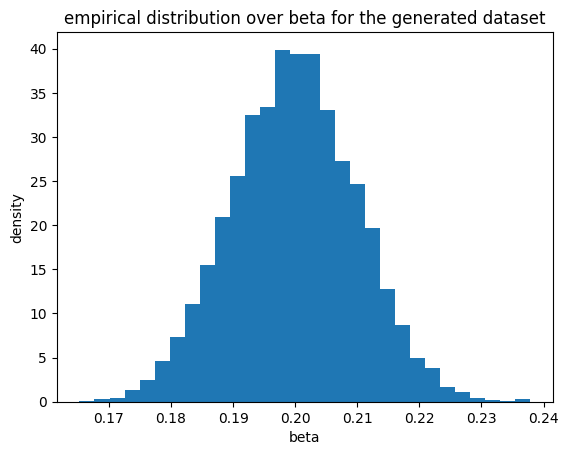

tensor(0.1998)


In [7]:
plt.hist(betas, density=True, bins=30)
plt.title("empirical distribution over beta for the generated dataset")
plt.xlabel("beta")
plt.ylabel("density")
plt.show()
print(t.mean(t.tensor(betas)))

In [4]:
def calc_distance(X, Y_sim:t.Tensor, Y_obs:t.Tensor) -> t.Tensor:
  # get statistics of the simulated set
  s_sim = S1(X, Y_sim)
  # get statistics of the observed set
  s_obs = S1(X, Y_obs)
  # calculate the mean ratio
  return (1 - t.mean(s_sim / (s_obs+1)))**2

In [5]:
X = dataset[:,0]
Y_obs = dataset[:,1]
calc_distance(X, Y_obs, model(X,0.5))

tensor(0.2689, dtype=torch.float64)

# ABC-PRC

In [10]:
# @title Run ABC-PRC for the example { vertical-output: true}
N = 2_000
X = dataset[:,0]
Y_obs = dataset[:,1]
epsilons = [0.6, 0.2, 0.05, 0.005]
mu_1 = uniform.Uniform(t.tensor(0.), t.tensor(1.)).sample_n

def kernel(beta:t.Tensor):
    return normal.Normal(beta, 0.1).sample()

betas, beta_hist, data_gen_hist = abc_prc(X, Y_obs, model, mu_1, kernel, calc_distance, epsilons, N)

c:\Users\jsche\anaconda3\envs\torchenv\lib\site-packages\torch\distributions\distribution.py:167: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


epsilon: 0.6


100%|██████████| 2000/2000 [17:37<00:00,  1.89it/s]


epsilon: 0.2


100%|██████████| 2000/2000 [17:03<00:00,  1.95it/s]


epsilon: 0.05


100%|██████████| 2000/2000 [25:07<00:00,  1.33it/s] 


epsilon: 0.005


100%|██████████| 2000/2000 [59:40<00:00,  1.79s/it] 


In [ ]:
beta_pdf = gaussian_pdf(mu, sigma**2)

x_vis = t.linspace(0,1,1_000)
y_vis = beta_pdf(x_vis)

fig, axs = plt.subplots(3,2, sharex=True, sharey=True)

axs[0,0].hist(beta_hist[0], density=True, bins=30)
axs[0,0].plot(x_vis, y_vis)
axs[0,0].set(ylabel='density', title="Population 0")
axs[0,1].hist(beta_hist[1], density=True, bins=30)
axs[0,1].plot(x_vis, y_vis)
axs[0,1].set(title="Population 1")
axs[1,0].hist(beta_hist[2], density=True, bins=30)
axs[1,0].plot(x_vis, y_vis)
axs[1,0].set( ylabel='density', title="Population 2")
axs[1,1].hist(beta_hist[3], density=True, bins=30)
axs[1,1].plot(x_vis, y_vis)
axs[1,1].set( title="Population 3")
axs[2,0].hist(beta_hist[4], density=True, bins=40)
axs[2,0].plot(x_vis, y_vis)
axs[2,0].set(xlabel='theta', title="Population 4")

plt.xlim(0,0.4)
plt.show()

In [20]:
print(t.mean(t.tensor(data_gen_hist[:2000], dtype=t.float)))
print(t.mean(t.tensor(data_gen_hist[2000:4000], dtype=t.float)))
print(t.mean(t.tensor(data_gen_hist[4000:6000], dtype=t.float)))
print(t.mean(t.tensor(data_gen_hist[6000:8000], dtype=t.float)))
len(data_gen_hist)

tensor(1.6785)
tensor(1.7045)
tensor(2.5710)
tensor(7.2645)


8000

# ABC-REJ

In [6]:
from abc_rej import abc_rej
from model import model_STE

X = dataset[:,0]
X = X.cuda()
Y_obs = dataset[:,1]
Y_obs = Y_obs.cuda()
epsilon = 0.005
prior = uniform.Uniform(0.,1.).sample

betas = []
step_hist = []
for i in tqdm(range(2000)):
    theta, num_steps = abc_rej(X, Y_obs, epsilon, prior, model_STE, calc_distance)
    betas.append(theta.detach().cpu().numpy())
    step_hist.append(num_steps)

100%|██████████| 2000/2000 [1:28:23<00:00,  2.65s/it]


(0.0, 0.4)

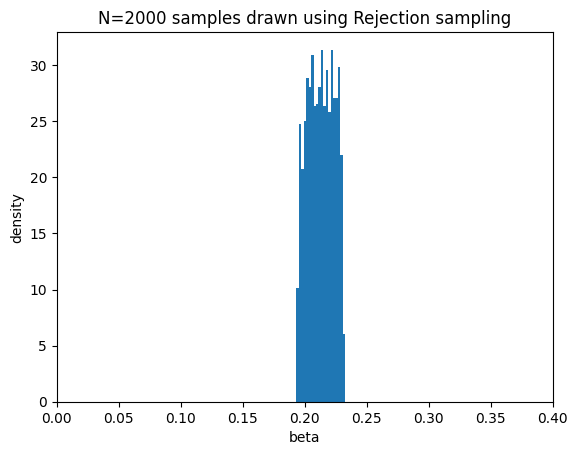

In [11]:
plt.hist(betas, density=True, bins=20)
plt.title("N=2000 samples drawn using Rejection sampling")
plt.ylabel("density")
plt.xlabel("beta")

plt.xlim(0,0.4)

In [14]:
t.mean(t.tensor(step_hist, dtype=t.float))

tensor(27.6265)

# ABC-MCMC

In [6]:
sigma = t.tensor(0.1)


def q(mu: t.Tensor) -> float:
    return t.clip(normal.Normal(mu, sigma.cuda()).sample().cuda(), 0, 1)


def gauss_likelihood(x: t.Tensor, y: t.Tensor) -> t.Tensor:
    pdf = gaussian_pdf(y, sigma**2)
    return pdf(x)


def uniform_likelihood(low: float, high: float, x: t.Tensor) -> float:
    if x > high or x < low:
        return 0
    else:
        return 1 / (high - low)


def calc_alpha(
    theta_star: t.Tensor, theta: t.Tensor, epsilon: float, dist: t.Tensor
) -> t.Tensor:
    if dist <= epsilon and uniform_likelihood(-10, 10, theta_star) > 0:
        ratio = gauss_likelihood(theta, theta_star) / gauss_likelihood(
            theta_star, theta
        )
        return t.min(t.tensor([t.tensor(1.0), ratio]).cuda())
    else:
        return t.tensor(0.0)

100%|██████████| 10000/10000 [21:39<00:00,  7.69it/s]

accepted 1462 samples


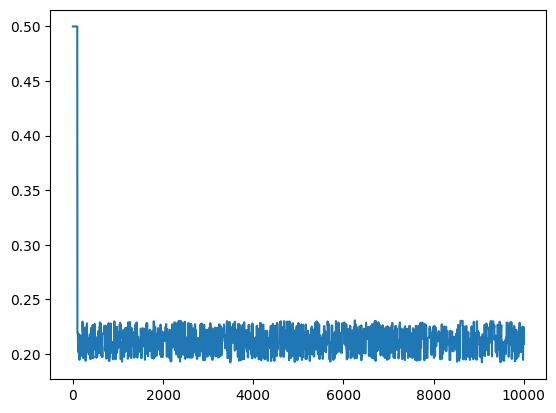

In [7]:
from abc_mcmc import abc_mcmc
from model import model_STE
N = 10000
X = dataset[:,0]
X = X.cuda()
Y_obs = dataset[:,1]
Y_obs = Y_obs.cuda()
epsilon = 0.005
beta_init = t.tensor(0.5).cuda()

betas, beta_hist, step_hist = abc_mcmc(X, Y_obs, beta_init, model_STE, calc_distance, calc_alpha, epsilon, q, N)

print(f"accepted {len(betas)} samples")

plt.plot(np.arange(len(beta_hist)), beta_hist)

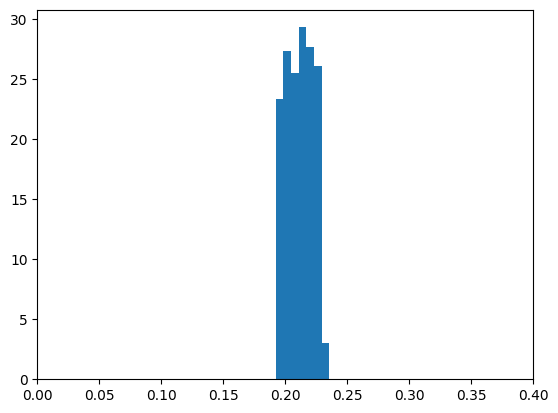

In [17]:
bins = plt.hist(np.array(betas), density=True, bins=50)
plt.xlim(0,0.4)
plt.show()

# Gradient Descent

In [18]:
def update(
    beta: t.Tensor, X: t.Tensor, Y_obs: t.Tensor, learning_rate: float
) -> t.Tensor:
    beta.requires_grad_()
    Y_sim = model_STE(X, beta)
    dist = calc_distance(X, Y_sim, Y_obs)
    gradient = t.autograd.grad(dist, beta)[0]
    return beta - learning_rate * gradient, gradient

def train(beta: t.Tensor, X: t.Tensor, Y_obs: t.Tensor, lr:float, num_steps:int):
    beta_hist = []
    grad_hist = []
    X = X.cuda()
    Y_obs = Y_obs.cuda()
    beta = beta.cuda()
    for i in tqdm(range(num_steps)):
        beta, gradient = update(beta, X, Y_obs, lr)
        beta_hist.append(beta.detach().clone().cpu().numpy())
        grad_hist.append(gradient.detach().clone().cpu().numpy())
    return beta, beta_hist, grad_hist

In [20]:
X = dataset[:, 0]
Y_obs = dataset[:, 1]
beta_init = uniform.Uniform(t.tensor(0.), t.tensor(1.)).sample()
lr = 0.01
num_steps = 1_000

beta, beta_hist, grad_hist = train(beta_init, X, Y_obs, lr, num_steps)

100%|██████████| 1000/1000 [02:09<00:00,  7.75it/s]


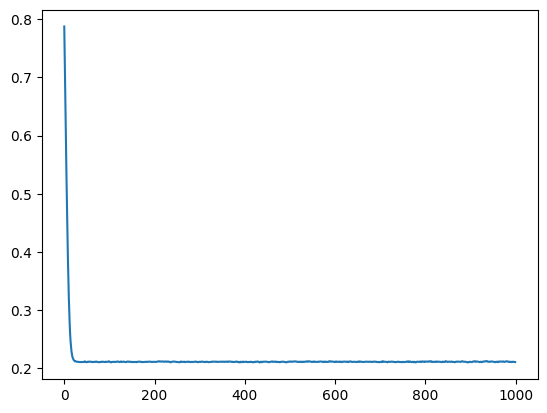

In [21]:
plt.plot(np.arange(len(beta_hist)), beta_hist)

In [22]:
X = dataset[:, 0]
Y_obs = dataset[:, 1]
beta_init = uniform.Uniform(t.tensor(0.), t.tensor(1.)).sample()
lr = 0.001
num_steps = 1_000

beta, beta_hist, grad_hist = train(beta_init, X, Y_obs, lr, num_steps)

100%|██████████| 1000/1000 [02:42<00:00,  6.17it/s]


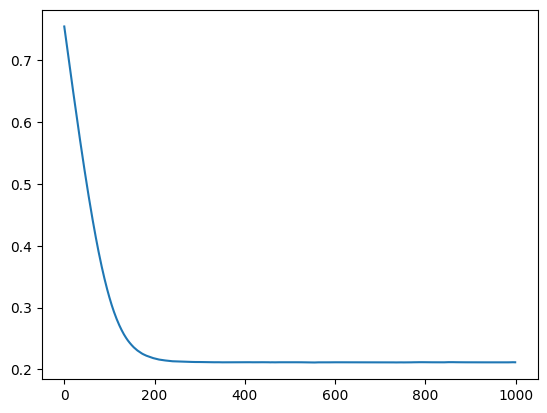

In [23]:
plt.plot(np.arange(len(beta_hist)), beta_hist)

# Stochastic Gradient Descent

In [24]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
class CustomDataset(Dataset):
    def __init__(self, beta_mu, beta_sigma, num_sequences, steps_per_sequence, grid_size):
        sequences = t.zeros((num_sequences, steps_per_sequence, grid_size, grid_size))
        self.betas = []

        for seq_idx in tqdm(range(num_sequences)):
            sequence = init_grids(grid_size,1)
            for step_idx in range(steps_per_sequence):
                beta = t.clip(normal.Normal(beta_mu, beta_sigma).sample(), 0, 1)
                sequences[seq_idx,step_idx,:,:] = sequence
                sequence = model_STE(sequence, beta)
                self.betas.append(beta.detach().cpu())

        dataset = chop_and_shuffle_data(sequences, shuffle=False)
        self.data = dataset

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], 0

In [26]:
training_data = CustomDataset(beta_mu=0.2, beta_sigma=0.01, num_sequences=500, steps_per_sequence=15, grid_size=25)
training_loader = DataLoader(training_data, batch_size=32, shuffle=True)

100%|██████████| 500/500 [00:04<00:00, 114.16it/s]


In [34]:
beta = uniform.Uniform(t.tensor(0.), t.tensor(1.)).sample()
beta = beta.cuda()
beta.requires_grad_()
lr = 0.001
epochs = 1_000
optimizer = t.optim.SGD([beta], lr=lr)

def train_loop(dataloader, optimizer):
    size = len(dataloader.dataset)
    beta_vals = []
    for batch, (transitions, y) in enumerate(dataloader):
        X = transitions[:, 0]
        X = X.cuda()
        Y_obs = transitions[:, 1]
        Y_obs = Y_obs.cuda()
        # Compute prediction and loss
        Y_sim = model_STE(X, beta)
        dist = calc_distance(X, Y_sim, Y_obs)

        # Backpropagation
        optimizer.zero_grad()
        dist.backward()
        optimizer.step()
        beta_vals.append(beta.detach().clone().cpu().numpy())
    return beta_vals

In [35]:
betas = [beta.detach().cpu().numpy()]
for epoch in tqdm(range(20)):
    betas = betas + train_loop(training_loader, optimizer)

100%|██████████| 20/20 [00:10<00:00,  1.83it/s]


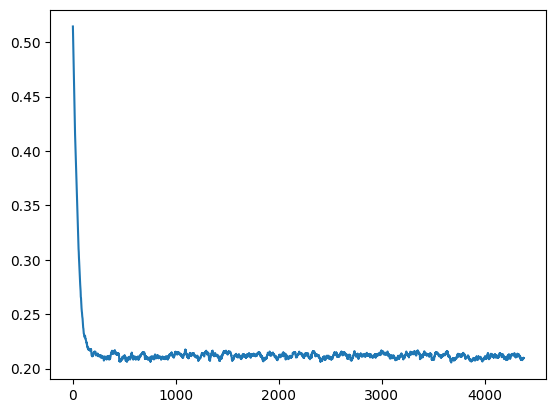

In [36]:
plt.plot(np.arange(len(betas)), betas)